In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
excel_file_path = "data.xlsx"

def validate_columns(data):
    col_names = data.columns
    
    # 1. Проверка на одинаковые названия столбцов
    if len(col_names) != len(set(col_names)):
        raise ValueError("Обнаружены столбцы с одинаковыми названиями.")
    
    versions = set()
    
    for col in col_names:
        # 2. Проверка названия столбцов
        match = re.match(r"(Retention|New_users)_(\d+)", col)
        if not match:
            raise ValueError(f"Столбец {col} не соответствует маске.")
        versions.add(int(match.group(2)))
    
    # 3. Проверка на наличие парных столбцов
    for ver in versions:
        if f"Retention_{ver}" not in col_names or f"New_users_{ver}" not in col_names:
            raise ValueError(f"Для версии {ver} не найдена пара столбцов.")
    
    # 4. Проверка на пустые значения
    if data.isnull().any().any():
        raise ValueError("Обнаружены пустые значения в таблице.")
    
    # 5. Проверка, что все значения числовые
    for col in col_names:
        if not pd.api.types.is_numeric_dtype(data[col]):
            raise ValueError(f"В столбце {col} обнаружены нечисловые значения.")
            
    # 6. Проверка на то что в столбце Retention значения в диапазоне [0, 1]
    for col in data.columns:
        if "Retention" in col:
            if not data[col].between(0, 1).all():
                raise ValueError(f"В столбце {col} обнаружены значения вне диапазона [0, 1].")
    
    return True

def import_data_from_excel(file_path):
    try:
        data = pd.read_excel(file_path)
        
        # Валидация данных после их загрузки
        validate_columns(data)
        
        return data

    except Exception as e:
        print("Error:", e)
        return None

data = import_data_from_excel(excel_file_path)

In [3]:
def calculate_mau_for_version(input_frame, version):
    retention_col = f'Retention_{version}'
    new_users_col = f'New_users_{version}'

    retention_rates = input_frame[retention_col].values
    new_users = input_frame[new_users_col].values
    
    # Создаем кумулятивную матрицу удержания
    n = len(new_users)
    cumulative_retention = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1):
            cumulative_retention[i, j] = retention_rates[i-j]
            
    # Умножаем матрицу на вектор новых пользователей
    mau = cumulative_retention @ new_users
    return mau

def insert_mau_to_data(original_data):
    versions = sorted(set(int(col.split('_')[-1]) for col in original_data.columns if "Retention" in col))
    
    for version in versions:
        mau_values = calculate_mau_for_version(original_data, version)
        original_data[f"MAU_{version}"] = mau_values
        
    # Сортируем столбцы по версиям
    sorted_columns = sum([[f"Retention_{version}", f"New_users_{version}", f"MAU_{version}"] for version in versions], [])
    original_data = original_data[sorted_columns]
        
    return original_data

# Добавляем расчеты MAU в исходный DataFrame
updated_data = insert_mau_to_data(data)
print(updated_data)

    Retention_1  New_users_1  MAU_1
0          1.00          100  100.0
1          0.15          100  115.0
2          0.08          100  123.0
3          0.05          100  128.0
4          0.04          100  132.0
5          0.03          100  135.0
6          0.02          100  137.0
7          0.01          100  138.0
8          0.00          100  138.0
9          0.00          100  138.0
10         0.00          100  138.0
11         0.00          100  138.0


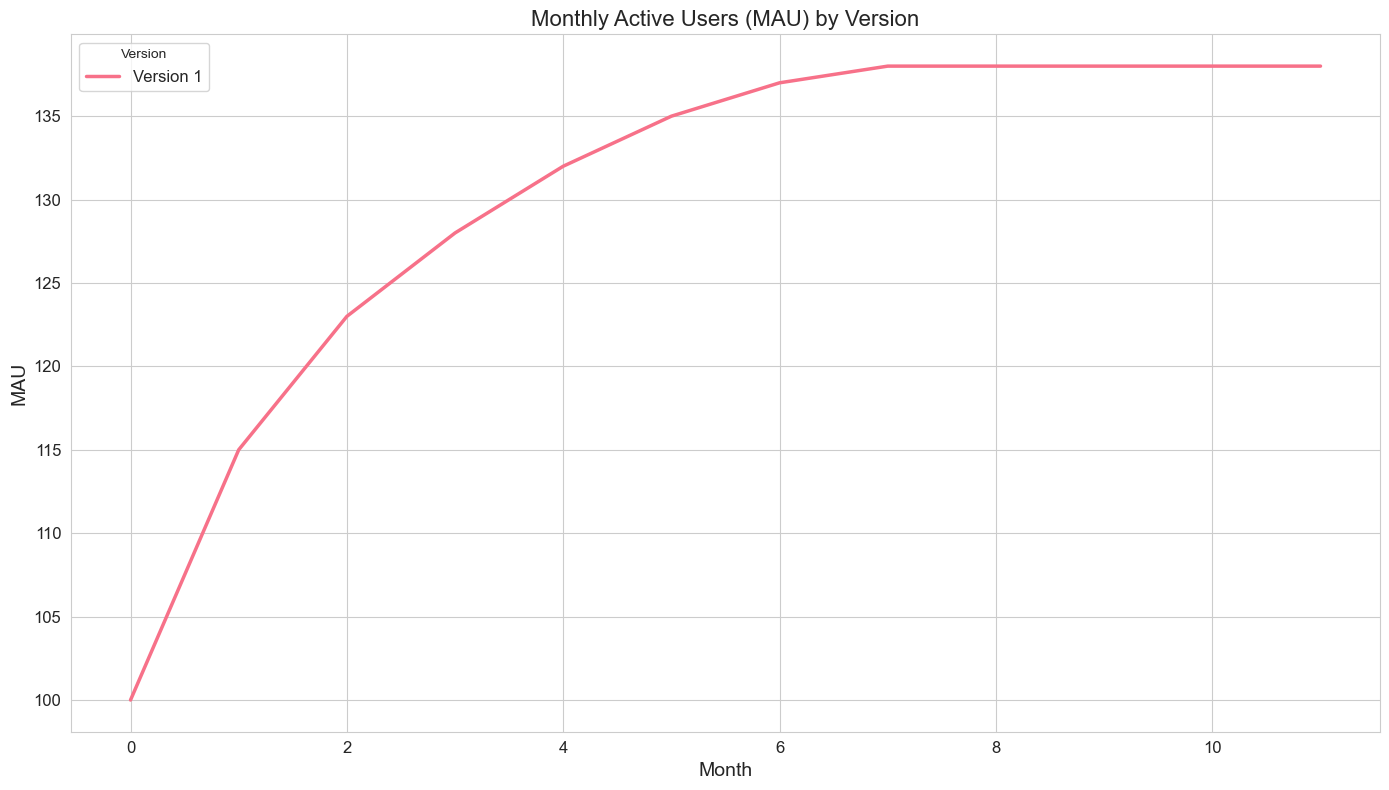

In [4]:
def plot_mau(data):
    # Устанавливаем стиль seaborn для красивых графиков
    sns.set_style("whitegrid")
    
    versions = sorted(set(int(col.split('_')[-1]) for col in data.columns if "MAU" in col))
    
    # Цветовая палитра
    palette = sns.color_palette("husl", len(versions))

    plt.figure(figsize=(14, 8))

    for idx, version in enumerate(versions):
        # Выбор данных для текущей версии
        mau_values = data[f"MAU_{version}"]

        sns.lineplot(x=data.index, y=mau_values, label=f"Version {version}", color=palette[idx], linewidth=2.5)

    plt.title("Monthly Active Users (MAU) by Version", fontsize=16)
    plt.xlabel("Month", fontsize=14)
    plt.ylabel("MAU", fontsize=14)
    plt.legend(title='Version', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

plot_mau(updated_data)


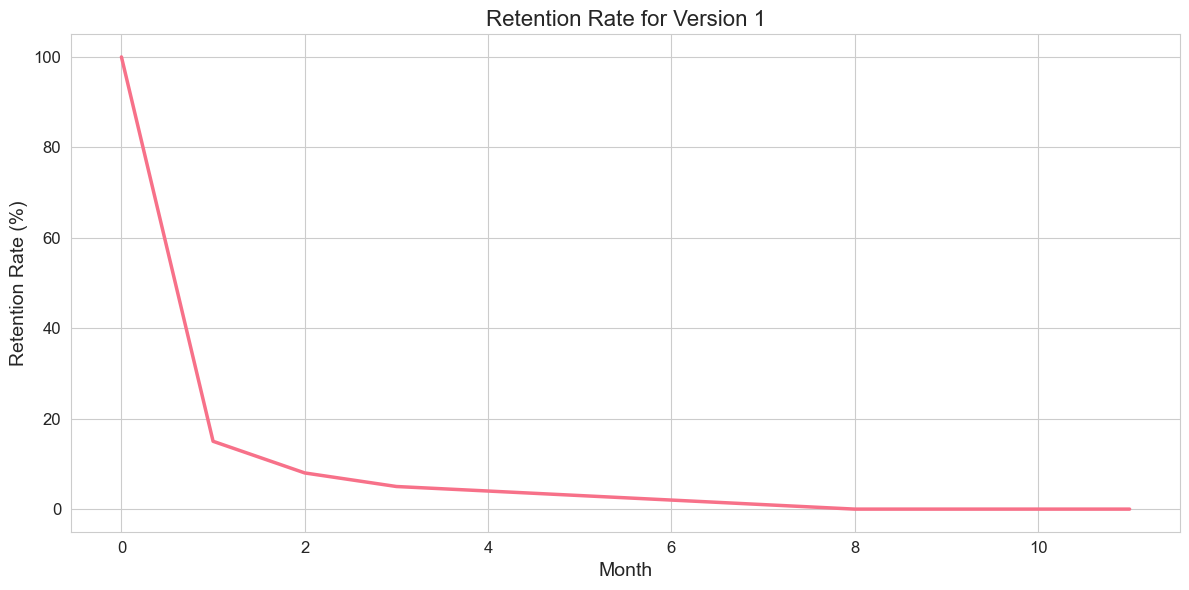

In [5]:
def plot_retention(data):
    # Устанавливаем стиль seaborn для красивых графиков
    sns.set_style("whitegrid")
    
    versions = sorted(set(int(col.split('_')[-1]) for col in data.columns if "Retention" in col))
    
    # Цветовая палитра
    palette = sns.color_palette("husl", len(versions))

    for idx, version in enumerate(versions):
        plt.figure(figsize=(12, 6))
        
        # Выбор данных для текущей версии
        retention_values = data[f"Retention_{version}"] * 100  # умножение на 100 для представления в процентах

        sns.lineplot(x=data.index, y=retention_values, color=palette[idx], linewidth=2.5)

        plt.title(f"Retention Rate for Version {version}", fontsize=16)
        plt.xlabel("Month", fontsize=14)
        plt.ylabel("Retention Rate (%)", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()

plot_retention(updated_data)